In [1]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
import os
import torch
from torch import nn, einsum
from einops import rearrange, repeat
import torch.nn.functional as F

# feedforward and attention
class GEGLU(nn.Module):
    def forward(self, x):
        x, gates = x.chunk(2, dim = -1)
        return x * F.gelu(gates)

def FeedForward(dim, mult = 4, dropout = 0.):
    return nn.Sequential(
        nn.LayerNorm(dim),
        nn.Linear(dim, dim * mult * 2),
        GEGLU(),
        nn.Dropout(dropout),
        nn.Linear(dim * mult, dim)
    )

class Attention(nn.Module):
    def __init__(
        self,
        dim,
        heads = 8,
        dim_head = 64,
        dropout = 0.
    ):
        super().__init__()
        inner_dim = dim_head * heads
        self.heads = heads
        self.scale = dim_head ** -0.5

        self.norm = nn.LayerNorm(dim)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)
        self.to_out = nn.Linear(inner_dim, dim, bias = False)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        h = self.heads

        x = self.norm(x)

        q, k, v = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), (q, k, v))
        q = q * self.scale

        sim = einsum('b h i d, b h j d -> b h i j', q, k)

        attn = sim.softmax(dim = -1)
        attn = self.dropout(attn)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)', h = h)
        return self.to_out(out)

# transformer
class Transformer(nn.Module):
    def __init__(
        self,
        dim,
        depth,
        heads,
        dim_head,
        attn_dropout,
        ff_dropout
    ):
        super().__init__()
        self.layers = nn.ModuleList([])

        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads = heads, dim_head = dim_head, dropout = attn_dropout),
                FeedForward(dim, dropout = ff_dropout),
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x

        return x

# numerical embedder
class NumericalEmbedder(nn.Module):
    def __init__(self, dim, num_numerical_types):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(num_numerical_types, dim))
        self.biases = nn.Parameter(torch.randn(num_numerical_types, dim))

    def forward(self, x):
        x = rearrange(x, 'b n -> b n 1')
        return x * self.weights + self.biases

# model 
class network(nn.Module) : 
    def __init__(
        self,
        categories,
        num_continuous,
        dim,
        depth,
        heads,
        dim_head = 16,
        dim_out = 1,
        num_special_tokens = 1, # CLS
        attn_dropout = 0.,
        ff_dropout = 0.
    ):
        super(network, self).__init__()
        assert all(map(lambda n: n > 0, categories)), 'number of each category must be positive'

        # categories related calculations
        self.num_categories = len(categories)
        self.num_unique_categories = sum(categories)

        # create category embeddings table
        self.num_special_tokens = num_special_tokens
        total_tokens = self.num_unique_categories + num_special_tokens

        # for automatically offsetting unique category ids to the correct position in the categories embedding table
        categories_offset = F.pad(torch.tensor(list(categories)), (1, 0), value = num_special_tokens)
        categories_offset = categories_offset.cumsum(dim = -1)[:-1]
        self.register_buffer('categories_offset', categories_offset)

        # categorical embedding
        self.categorical_embeds = nn.Embedding(total_tokens, dim)

        # continuous
        self.numerical_embedder = NumericalEmbedder(dim, num_continuous)

        # cls token
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))

        # transformer
        self.transformer = Transformer(            
            dim = dim,
            depth = depth,
            heads = heads,
            dim_head = dim_head,
            attn_dropout = attn_dropout,
            ff_dropout = ff_dropout
        )
        
        self.linear_stack = nn.Sequential(
            nn.LayerNorm(dim),
            nn.ReLU(), 
            nn.Linear(dim, dim_out),
            nn.Sigmoid())

    def forward(self, x_categ, x_numer):
        b = x_categ.shape[0]

        assert x_categ.shape[-1] == self.num_categories, f'you must pass in {self.num_categories} values for your categories input'
        x_categ += self.categories_offset

        x_categ = self.categorical_embeds(x_categ)

        # add numerically embedded tokens

        x_numer = self.numerical_embedder(x_numer)

        # concat categorical and numerical

        x = torch.cat((x_categ, x_numer), dim = 1)

        # append cls tokens

        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat((cls_tokens, x), dim = 1)

        # attend

        x = self.transformer(x)

        # get cls token

        x = x[:, 0]

        return self.linear_stack(x)

In [4]:
import torch.optim as optim # call for optimizer
from torchvision import datasets, transforms # for dataset processing 

is_cuda = torch.cuda.is_available() ; is_cuda # gpu 사용가능한가 확인 # true
device = torch.device('cuda' if is_cuda else 'cpu') # device(type='cuda'). cpu 또는 gpu 로 장비 사용 설정

In [5]:
device

device(type='cuda')

In [6]:
# hyperparameter 지정 
batch_size = 50 # 미니배치 사이즈 
epoch_num = 800 # epoch 수 
learning_rate = 0.001 # step size (=learning rate)

In [7]:
# 데이터셋 로드 
import pandas as pd 
import matplotlib.pyplot as plt 

smoking = pd.read_csv('/Users/user/Desktop/smoking.csv') ; smoking 

,ID,gender,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),...,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,oral,dental caries,tartar,smoking
0,0,F,40,155,60,81.3,1.2,1.0,1.0,1.0,...,12.9,1.0,0.7,18.0,19.0,27.0,Y,0,Y,0
1,1,F,40,160,60,81.0,0.8,0.6,1.0,1.0,...,12.7,1.0,0.6,22.0,19.0,18.0,Y,0,Y,0
2,2,M,55,170,60,80.0,0.8,0.8,1.0,1.0,...,15.8,1.0,1.0,21.0,16.0,22.0,Y,0,N,1
3,3,M,40,165,70,88.0,1.5,1.5,1.0,1.0,...,14.7,1.0,1.0,19.0,26.0,18.0,Y,0,Y,0
4,4,F,40,155,60,86.0,1.0,1.0,1.0,1.0,...,12.5,1.0,0.6,16.0,14.0,22.0,Y,0,N,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55687,55676,F,40,170,65,75.0,0.9,0.9,1.0,1.0,...,12.3,1.0,0.6,14.0,7.0,10.0,Y,1,Y,0
55688,55681,F,45,160,50,70.0,1.2,1.2,1.0,1.0,...,14.0,1.0,0.9,20.0,12.0,14.0,Y,0,Y,0
55689,55683,F,55,160,50,68.5,1.0,1.2,1.0,1.0,...,12.4,1.0,0.5,17.0,11.0,12.0,Y,0,N,0
55690,55684,M,60,165,60,78.0,0.8,1.0,1.0,1.0,...,14.4,1.0,0.7,20.0,19.0,18.0,Y,0,N,0


In [8]:
smoking.drop(columns=['ID', 'gender', 'height(cm)','hearing(right)', 'hearing(left)', 'eyesight(right)', 'eyesight(left)', 'Urine protein'], inplace=True)

In [9]:
smoking.drop(columns=['oral'], inplace=True)

In [10]:
smoking = pd.get_dummies(smoking, drop_first=True)

In [11]:
from sklearn.preprocessing import MinMaxScaler 

mm = MinMaxScaler()
scaler = ['age','weight(kg)', 'waist(cm)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin','serum creatinine', 'AST',
       'ALT', 'Gtp']

mm.fit(smoking[scaler])
smoking[scaler] = mm.transform(smoking[scaler])

In [12]:
X = smoking.drop(columns=['smoking']).values
y = smoking['smoking'].values

In [13]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_target_x, test_target_x = train_test_split(X, y, test_size=0.2, random_state=156)
test_x, valid_x, test_target_x, valid_target_x = train_test_split(test_x, test_target_x, test_size=0.2, random_state=156)

In [14]:
print(train_x.shape)
print(test_x.shape)
print(valid_x.shape)

(44553, 17)
(8911, 17)
(2228, 17)


In [15]:
# train x
x_categ_train = train_x[:, [-1, -2]]
x_numer_train = train_x[:, : -2]

# test x
x_categ_test = test_x[:, [-1, -2]]
x_numer_test = test_x[:, : -2]

In [16]:
# valid x
x_categ_valid = valid_x[:, [-1, -2]]
x_numer_valid = valid_x[:, : -2]

In [17]:
# 실험
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
# Dataset 상속
import numpy as np 
class CustomDataset(Dataset): 
    def __init__(self):
        self.x_data = x_categ_train
        self.x2_data = x_numer_train
        self.y_data = train_target_x

  # 총 데이터의 개수를 리턴
    def __len__(self): 
        return len(self.x_data)

  # 인덱스를 입력받아 그에 맵핑되는 입출력 데이터를 파이토치의 Tensor 형태로 리턴
    def __getitem__(self, idx): 
        x = torch.Tensor(self.x_data[idx]) # categ
        x2 = torch.Tensor(self.x2_data[idx]) # numeric
        y = torch.Tensor(train_target_x.reshape(len(train_target_x), 1))[idx]
        return (x, x2), y

dataset = CustomDataset()
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [18]:
model = network(categories=(2,2), 
       num_continuous=15, 
       dim = 32, 
       depth=8, # transformer layer 수
       heads=8, attn_dropout=0.2, ff_dropout=0.2).to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()

In [19]:
# train 함수 정의 
def train(model, dataloader, optimizer, criterion, device) : 
    model.train()
    epoch_loss = 0 
    for batch_idx, samples in enumerate(dataloader) : 
        x_train, y_train = samples 
        x_categ, x_numer = x_train # tuple 언패킹
        x_categ = x_categ.type(torch.IntTensor)
        
        x_categ = x_categ.to(device)
        x_numer = x_numer.to(device)
        y_train = y_train.to(device)
        
        optimizer.zero_grad()
        
        output = model(x_categ, x_numer)
        loss = criterion(output, y_train) # batch 에 대한 loss
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() # 이번 epoch 에서 loss 총합
        
    return epoch_loss / len(dataloader) # 이번 epoch 에서 loss 평균 

In [20]:
# 테스트셋 구성
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
# Dataset 상속
import numpy as np 
class Customtestset(Dataset): 
    def __init__(self):
        self.x_data = x_categ_test
        self.x2_data = x_numer_test
        self.y_data = test_target_x

  # 총 데이터의 개수를 리턴
    def __len__(self): 
        return len(self.x_data)

  # 인덱스를 입력받아 그에 맵핑되는 입출력 데이터를 파이토치의 Tensor 형태로 리턴
    def __getitem__(self, idx): 
        x = torch.Tensor(self.x_data[idx]) # categ
        x2 = torch.Tensor(self.x2_data[idx]) # numeric
        y = torch.Tensor(self.y_data.reshape(len(self.y_data), 1))[idx]
        return (x, x2), y
    
testset = Customtestset()
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)

In [21]:
# 테스트셋에서 모델 성능 평가 함수 , 평가지표 accuracy rate 사용.
def evaluate(model, testloader, device) : 
    model.eval()  
    error = 0
    with torch.no_grad() : 
        for batch_idx, samples in enumerate(testloader) : 
            x_test, y_test = samples
            x_categ_test, x_numer_test = x_test # tuple 언패킹
            x_categ_test = x_categ_test.type(torch.IntTensor)

            x_categ_test = x_categ_test.to(device)
            x_numer_test = x_numer_test.to(device)
            y_test = y_test.to(device)

            output = model(x_categ_test, x_numer_test)
            prediction = torch.Tensor([0 if x <= 0.5 else 1 for x in output.data]).to(device)
            error += prediction.ne(torch.flatten(y_test)).sum().item() # 이번 Epoch 에서 틀린 것 총 갯수 누적 
            
    return error/len(testloader.dataset) # 이번 Epoch 에서 error rate, accuracy rate

In [22]:
train_loss_list = []
test_error_list = []

for epoch in range(epoch_num) : 
    # epoch 당 train loss
    train_loss = train(model, dataloader, optimizer, criterion, device) 
    test_error = evaluate(model, testloader, device)
    
    train_loss_list.append(train_loss)
    test_error_list.append(test_error)
    
    print(f'Epoch: {epoch}')
    print(f'Train loss: {round(train_loss, 3)}')
    print(f'Test loss: {round(test_error, 3)}')

Epoch: 0
Train loss: 0.551
Test loss: 0.287
Epoch: 1
Train loss: 0.528
Test loss: 0.292
Epoch: 2
Train loss: 0.522
Test loss: 0.281
Epoch: 3
Train loss: 0.518
Test loss: 0.273
Epoch: 4
Train loss: 0.514
Test loss: 0.285
Epoch: 5
Train loss: 0.513
Test loss: 0.273
Epoch: 6
Train loss: 0.511
Test loss: 0.276
Epoch: 7
Train loss: 0.509
Test loss: 0.268
Epoch: 8
Train loss: 0.506
Test loss: 0.266
Epoch: 9
Train loss: 0.505
Test loss: 0.267
Epoch: 10
Train loss: 0.502
Test loss: 0.288
Epoch: 11
Train loss: 0.501
Test loss: 0.273
Epoch: 12
Train loss: 0.499
Test loss: 0.261
Epoch: 13
Train loss: 0.498
Test loss: 0.259
Epoch: 14
Train loss: 0.498
Test loss: 0.264
Epoch: 15
Train loss: 0.496
Test loss: 0.259
Epoch: 16
Train loss: 0.495
Test loss: 0.26
Epoch: 17
Train loss: 0.495
Test loss: 0.258
Epoch: 18
Train loss: 0.494
Test loss: 0.27
Epoch: 19
Train loss: 0.494
Test loss: 0.268
Epoch: 20
Train loss: 0.492
Test loss: 0.26
Epoch: 21
Train loss: 0.493
Test loss: 0.252
Epoch: 22
Train loss: 0

KeyboardInterrupt: 

In [24]:
torch.save(model.state_dict(), '/Users/user/Desktop/20221206_fttrans_status.pt')

In [23]:
# 커스텀 테스트셋 구성
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
# Dataset 상속
import numpy as np 
class Customvalidset(Dataset): 
    def __init__(self):
        self.x_data = x_categ_valid
        self.x2_data = x_numer_valid
        self.y_data = valid_target_x

  # 총 데이터의 개수를 리턴
    def __len__(self): 
        return len(self.x_data)

  # 인덱스를 입력받아 그에 맵핑되는 입출력 데이터를 파이토치의 Tensor 형태로 리턴
    def __getitem__(self, idx): 
        x = torch.Tensor(self.x_data[idx]) # categ
        x2 = torch.Tensor(self.x2_data[idx]) # numeric
        y = torch.Tensor(self.y_data.reshape(len(self.y_data), 1))[idx]
        return (x, x2), y
    
validset = Customvalidset()
validloader = DataLoader(validset, batch_size=batch_size, shuffle=True)


# 테스트셋에서 모델 성능 평가 
model.eval() 

correct = 0 
valid = 1
for batch_idx, samples in enumerate(validloader) : 
    x_valid, y_valid = samples
    x_categ_valid, x_numer_valid = x_valid # tuple 언패킹
    x_categ_valid = x_categ_valid.type(torch.IntTensor)
    
    x_categ_valid = x_categ_valid.to(device)
    x_numer_valid = x_numer_valid.to(device)
    y_valid = y_valid.to(device)
    
    output = model(x_categ_valid, x_numer_valid)
    prediction = torch.Tensor([0 if x <= 0.5 else 1 for x in output.data]).to(device)

    correct += prediction.eq(torch.flatten(y_valid)).sum()
    
    valid += 1
    
print('Validation set: Accuracy: {:.2f}%'.format(100*correct/len(validloader.dataset)))

Validation set: Accuracy: 79.31%


# transformer layer 1 : validation set 77.47% epoch 669, 
# transformer layer 2: validation set 78.14% epoch 559,
# transformer layer 3: validation set 78.95% epoch 800, 
# transformer alyer 4: validation set 80.66%, train loss=0.225, test loss=0.222 epoch 501, 
# transformer layer 8 dropout=0.2: validation set 79.31%, epoch 577, train loss 0.103, test loss = 0.221

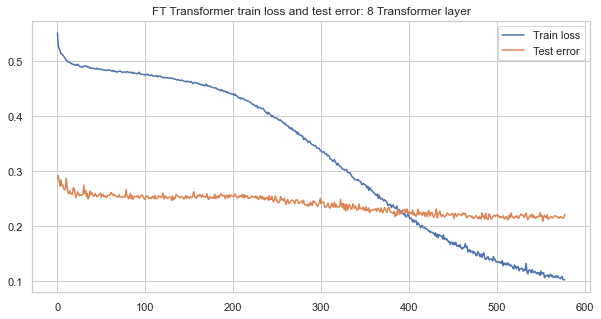

In [25]:
# 시각화 
%matplotlib inline
import matplotlib.pyplot as plt 

plt.figure(figsize=(10,5))
plt.plot(range(len(train_loss_list)), train_loss_list, label='Train loss')
plt.plot(range(len(test_error_list)), test_error_list, label='Test error')
plt.title('FT Transformer train loss and test error: 8 Transformer layer')
plt.legend()
plt.show()